# Securities portfolio modeling. Allocation, optimization and analysis
### Kirill Zakharov
#### telegram: @kirillzx

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sts
import yfinance as yf
from scipy.optimize import linprog
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import datetime
plt.style.use('ggplot')

In [205]:
class Portfolio:
    def __init__(self, names, dates):
        self.n = len(names)
        self.names = names
        self.data = pd.DataFrame()
        self.new_data = pd.DataFrame()
        self.w = np.array([1/self.n]*self.n)
        self.month_return = 0
        self.month_COV = 0
        self.month_risk = 0
        
    def get_ts(self):
        self.data = pd.DataFrame(columns=self.names)
        for name in self.names:
            self.data[name] = yf.download(name, dates[0], dates[1])['Adj Close']
            
    def get_ts_csv(self):
        self.data = pd.read_csv('quotes.csv', sep='\t', parse_dates=True, index_col='Date')
            
    def graphics(self):
        if self.data.empty:
            print('At first, use get_ts() for download data')
        else:
            fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
            (self.data.pct_change()+1).cumprod().plot(ax=ax)
            plt.show()
            
    def resample_to_months(self):
        self.new_data = self.data.resample('M').last()
    
#     def get_month_return(self):
#         self.month_return = self.new_data.pct_change().mean()
#         return self.month_return
    
    def get_month_return(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).mean()
    
#     def get_month_COV(self):
#         self.month_COV = self.new_data.pct_change().cov()
#         return self.month_COV
    
    def get_month_COV(self):
        return self.new_data.pct_change(1).apply(lambda x: np.log(1+x)).cov()
    
    def get_month_risk(self, w):
        self.month_risk = np.dot(np.dot(w, self.get_month_COV()), w)
        return self.month_risk
    
    def get_returnP(self):
        return np.dot(self.w, self.get_month_return())
    
    def get_returnP_free(self, rf):
        return np.dot(self.w[:self.n], self.get_month_return()) + self.w[self.n] * rf
    
    def get_riskP(self):
        return np.dot(np.dot(self.w, self.get_month_COV()), self.w)
    
    def get_riskP_free(self):
        return np.dot(np.dot(self.w[:self.n], self.get_month_COV()), self.w[:self.n])

In [504]:
class OptimizationP(Portfolio):
    def __init__(self, names, dates):
        super().__init__(names, dates)
        self.bnds = tuple([(0.05, 0.15) for i in range(self.n)])
        self.init = np.repeat(0.05, self.n)
        self.cons = 0
        self.opt1 = 0
        p = Portfolio(names, dates)
        self.free_cov_matrix = 0
        self.free_month_return = 0
        self.cov_matrix = 0
        self.return1 = 0
        
    def get_help(self):
        print('maxReturn - maximize return of the portfolio\nminRisk - minimize risk of the portfolio',\
              '\nmaxSharpe - maximize a Sharpe ratio\nmaxSortino - maximize a Sortino ratio',\
             '\nminGenFun - minimize generalized function')    
    
    def optimizeP(self, type_opt, boundsP, initP, rf=0.0037, t=0.5):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        if type_opt == 'maxReturn':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
#                         {'type':'ineq', 'fun': lambda x: -np.dot(x, np.dot(self.cov_matrix, x))+0.003})
            
            self.opt1 = minimize(lambda x: -np.dot(x, self.return1), self.init,\
                                 bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minRisk':
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
#                         {'type':'ineq', 'fun': lambda x: np.dot(self.return1, x)-0.02})
            
            self.opt1 = minimize(lambda x: np.dot(np.dot(x, self.cov_matrix), x), self.init,\
                                 method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSharpe':
            
            def sharpe_f(x):
                return -(np.dot(self.return1, x) - rf)/np.dot(np.dot(x, self.cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sharpe_f, self.init, method='SLSQP', bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'maxSortino':
            r = self.return1
            array = []
            
            for i in range(len(r)):
                if r[i] < rf:
                    array.append(r[i])
            r2 = 0        
            
            for i in range(len(array)):
                r2 += (array[i] - rf)**2
            
            def sortino_f(x):
                return -(np.dot(self.return1, x) - rf)/np.sqrt(r2/self.n)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(sortino_f, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minGenFun':
            
            def genFun(x):
                return -t * np.dot(self.return1, x) + 0.5 * np.dot(np.dot(x, self.cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n)])
            self.init = np.repeat(initP, self.n)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n), x)-1})
            
            self.opt1 = minimize(genFun, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        elif type_opt == 'minGenFunFree':
            
            self.free_cov_matrix = np.vstack((np.hstack((self.cov_matrix, np.zeros((self.n,1)))), np.zeros(self.n+1)))
            self.free_month_return = np.append(self.return1, rf)
            
            def genFunFree(x):
                return -t * np.dot(self.free_month_return, x) + 0.5 * np.dot(np.dot(x, self.free_cov_matrix), x)
            
            self.bnds = tuple([(boundsP[0], boundsP[1]) for i in range(self.n+1)])
            self.init = np.repeat(initP, self.n+1)
            self.cons = ({'type':'eq', 'fun': lambda x: np.dot(np.ones(self.n+1), x)-1})
            
            self.opt1 = minimize(genFunFree, self.init, bounds=self.bnds, constraints=self.cons)
            self.w = self.opt1.x
            
            return self.opt1
        
        else:
            return 'Choose the type of optimization. Use Object.get_help() to learn more.'
        
    def multi_criteria_opt(self, boundsP, initP, rf, t):
        self.cov_matrix = self.get_month_COV()
        self.return1 = self.get_month_return()
        
        f1 = -self.optimizeP('maxReturn', boundsP, initP, rf, t).fun
        f2 = -self.optimizeP('maxSharpe', boundsP, initP, rf, t).fun
        f3 = self.optimizeP('minGenFun', boundsP, initP, rf, t).fun
        
        r1 = np.append(self.return1, f1)
        r2 = np.append(self.return1, f2)
        r3 = np.append(self.return1, f3)
        
        def sharpe_f(x):
                return (np.dot(self.return1, x) - rf)/np.sqrt(np.dot(np.dot(x, self.cov_matrix), x))
        
        def genFun(x, t):
                return -t * np.dot(self.return1, x) + 0.5 * np.dot(np.dot(x, self.cov_matrix), x)
        
        def fun_x(x):
            array = np.zeros(self.n)
            array = np.append(array, 1)
            return np.dot(array, x)
            
        self.bnds = [(boundsP[0], boundsP[1]) for i in range(self.n)]
        self.bnds.append((0, 1))
        self.bnds = tuple(self.bnds)
        
        self.init = np.repeat(initP, self.n+1)
        self.cons = [{'type':'eq', 'fun': lambda x: np.dot(x[:self.n], np.ones(self.n))-1},
                    {'type':'ineq', 'fun': lambda x: np.array([-f1 + np.dot(x[:self.n], \
                                                                self.return1) + f1*x[self.n],
                                                              -f2 + sharpe_f(x[:self.n]) + f2*x[self.n]
                                                              -genFun(x[:self.n], t) + f3 + f3*x[self.n]])}]
            
        self.opt1 = minimize(lambda x: x[self.n], self.init, bounds=self.bnds, constraints=self.cons)
        self.w = self.opt1.x[:self.n]
            
        return self.opt1
    
    def optimal_t(self):
        l = np.ones(self.n)
        inv_COV = np.linalg.inv(self.get_month_COV())
        r = self.get_month_return()
        
        h0 = np.dot(l, inv_COV)/np.dot(np.dot(l, inv_COV), l)
        h1 = np.dot(inv_COV, r) - np.dot(inv_COV, l)*np.dot(np.dot(l, inv_COV), r)/np.dot(np.dot(l, inv_COV), l)
        
        alpha0 = np.dot(r, h0)
        alpha1 = np.dot(r, h1)
        beta0 = np.dot(np.dot(h0, self.get_month_COV()), h0)
        
        return (h0, h1, alpha0, alpha1, beta0)
    

In [4]:
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
dates = ('2018-01-01', '2021-04-01')
portfolio1 = Portfolio(names, dates)

In [5]:
portfolio1.get_ts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
portfolio1.data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-03,154.489380,107.051125,197.995163,5095.507324,26.139996,0.638334,127.199066,70.177948,41.373032,255.418671
2018-01-04,159.086075,110.039169,202.738434,5208.654297,26.392916,0.650833,134.899857,71.621933,41.565216,256.524994
2018-01-05,158.952835,111.035172,202.199417,5283.299316,26.435070,0.654023,133.450317,71.621933,42.038452,258.147003
2018-01-09,160.151993,113.367302,203.421158,5185.867676,26.528746,0.654885,136.349426,71.116539,41.877506,259.309631


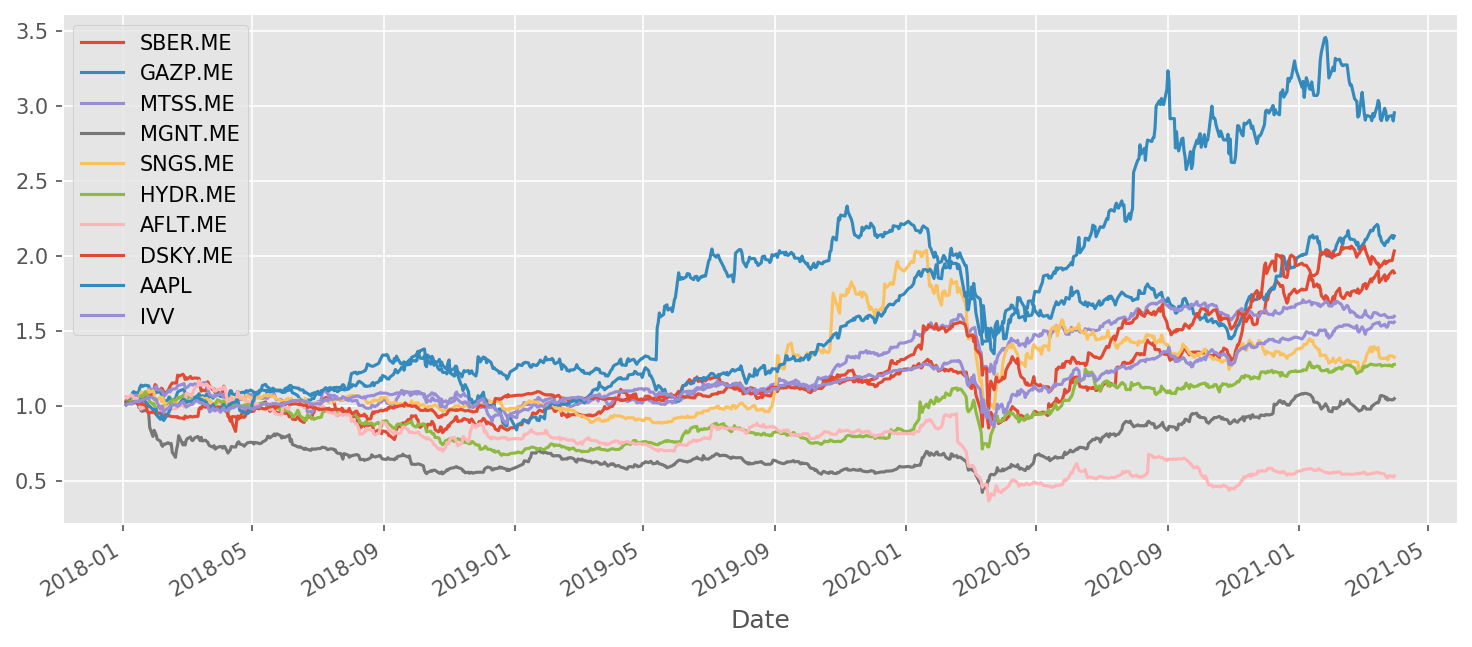

In [7]:
portfolio1.graphics()

In [8]:
portfolio1.resample_to_months()
portfolio1.new_data.head(4)

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
Date,,,,,,,,,,
2018-01-31,176.207153,116.088120,222.070801,4187.981445,26.922180,0.625404,120.766647,66.784569,40.219990,266.416565
2018-02-28,181.470032,115.926170,221.064667,3757.396973,26.898762,0.673677,128.150345,65.340576,42.962379,256.281250
2018-03-31,168.925705,115.254066,211.398468,3677.251709,26.575584,0.663678,140.969910,69.636444,40.468391,249.931442
2018-04-30,151.218384,118.169220,213.015472,3851.685303,27.577906,0.642213,130.460587,67.434357,39.860565,250.816803


In [9]:
portfolio1.get_month_return()

SBER.ME    0.017025
GAZP.ME    0.021329
MTSS.ME    0.010338
MGNT.ME    0.009673
SNGS.ME    0.009748
HYDR.ME    0.009006
AFLT.ME   -0.008936
DSKY.ME    0.022915
AAPL       0.034300
IVV        0.011985
dtype: float64

In [10]:
portfolio1.get_month_COV()

,SBER.ME,GAZP.ME,MTSS.ME,MGNT.ME,SNGS.ME,HYDR.ME,AFLT.ME,DSKY.ME,AAPL,IVV
SBER.ME,0.007742,0.003621,0.002223,0.002937,0.002593,0.002721,0.005487,0.004310,0.002679,0.003000
GAZP.ME,0.003621,0.007453,0.001523,0.001071,0.003036,0.000592,0.004225,0.001905,0.001277,0.001716
MTSS.ME,0.002223,0.001523,0.002119,0.001550,0.001581,0.001655,0.002262,0.001176,0.002558,0.001493
MGNT.ME,0.002937,0.001071,0.001550,0.006899,0.000678,0.002883,0.002790,0.001849,0.002440,0.001802
SNGS.ME,0.002593,0.003036,0.001581,0.000678,0.006829,0.000291,0.003697,0.001473,0.002672,0.001987
HYDR.ME,0.002721,0.000592,0.001655,0.002883,0.000291,0.004411,0.002496,0.002341,0.002095,0.001367
AFLT.ME,0.005487,0.004225,0.002262,0.002790,0.003697,0.002496,0.012188,0.004685,0.004531,0.003951
DSKY.ME,0.004310,0.001905,0.001176,0.001849,0.001473,0.002341,0.004685,0.005999,0.001874,0.001629
AAPL,0.002679,0.001277,0.002558,0.002440,0.002672,0.002095,0.004531,0.001874,0.009614,0.003541
IVV,0.003000,0.001716,0.001493,0.001802,0.001987,0.001367,0.003951,0.001629,0.003541,0.002812


In [11]:
portfolio1.get_month_risk(portfolio1.w)

0.002825900945987014

## Portfolio optimization

In [568]:
rf = 0.0037
# names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
names = ['AAPL', 'AMZN', 'IBM', 'SBER.ME']
dates = ('2018-01-01', '2021-02-01')
n = len(names)

portfolio_opt = OptimizationP(names, dates)
portfolio_opt.get_help()

maxReturn - maximize return of the portfolio
minRisk - minimize risk of the portfolio 
maxSharpe - maximize a Sharpe ratio
maxSortino - maximize a Sortino ratio 
minGenFun - minimize generalized function


In [569]:
# portfolio_opt.get_ts_csv()
portfolio_opt.get_ts()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [570]:
portfolio_opt.resample_to_months()

In [571]:
p_return = portfolio_opt.get_month_return()
p_cov = portfolio_opt.get_month_COV()

## Equally allocation

In [572]:
portfolio_opt.w

array([0.25, 0.25, 0.25, 0.25])

In [573]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 1.519 %
Risk: 0.468 %


## Maximize return

In [574]:
max_return = portfolio_opt.optimizeP('maxReturn', (0, 1), 0, rf)
max_return

     fun: -0.03296226495727207
     jac: array([-0.03296226, -0.02202526,  0.00488295, -0.01064973])
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.15105711e-16])

In [575]:
max_return_ret = round(np.dot(p_return, max_return.x), 3)*100
max_return_risk = round(np.dot(max_return.x, np.dot(p_cov, max_return.x)), 3)*100

print(f'Return: {round(max_return_ret, 3)} %')
print(f'Risk: {round(max_return_risk, 3)} %')

Return: 3.3 %
Risk: 0.9 %


## Maximize Sharpe ratio

In [576]:
max_sharpe = portfolio_opt.optimizeP('maxSharpe', (0, 1), 0.01, rf)
max_sharpe

     fun: -3.844841719904044
     jac: array([3.16469857, 3.16655049, 6.32406896, 3.16637745])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.59160899e-01, 3.29743486e-01, 4.75281217e-15, 2.11095615e-01])

In [577]:
max_sharpe_ret = round(np.dot(p_return, max_sharpe.x)*100, 3)
max_sharpe_risk = round(np.dot(np.dot(max_sharpe.x, p_cov), max_sharpe.x)*100, 3)
max_sharpe_ratio = -max_sharpe.fun

print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')
print(f'Sharpe ratio: {round(max_sharpe_ratio, 3)}')

Return: 2.465 %
Risk: 0.545 %
Sharpe ratio: 3.845


## Maximize Sortino ratio

In [578]:
portfolio_opt.optimizeP('maxSortino', (0.05, 0.15), 0, rf)

     fun: -1.2613715475006593
     jac: array([-7.68087049, -5.13232771,  1.13782559, -2.48160034])
 message: 'Positive directional derivative for linesearch'
    nfev: 146
     nit: 15
    njev: 11
  status: 8
 success: False
       x: array([0.15, 0.15, 0.15, 0.15])

In [579]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 0.911 %
Risk: 0.168 %


## Minimize risk

In [580]:
min_risk = portfolio_opt.optimizeP('minRisk', (0, 1), 0, rf)
min_risk

     fun: 0.0046097360047434215
     jac: array([0.00921845, 0.00892214, 0.0095095 , 0.00922843])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.17740415, 0.24723544, 0.24384539, 0.33151501])

In [581]:
min_risk_ret = round(np.dot(p_return, min_risk.x)*100, 3)
min_risk_risk = round(np.dot(np.dot(min_risk.x, p_cov), min_risk.x)*100, 3)

print(f'Return: {round(min_risk_ret, 3)} %')
print(f'Risk: {min_risk_risk} %')

Return: 1.363 %
Risk: 0.461 %


## Minimize generalized function

In [582]:
portfolio_opt.optimizeP('minGenFun', (0.05, 0.15), 0, rf, 0.5)

     fun: -0.0037144876564227554
     jac: array([-0.01342494, -0.00819309,  0.00526654, -0.00279786])
 message: 'Positive directional derivative for linesearch'
    nfev: 476
     nit: 35
    njev: 31
  status: 8
 success: False
       x: array([0.15, 0.15, 0.15, 0.15])

In [466]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 0.911 %
Risk: 0.168 %


## Minimize generalized function with free risk asset

In [403]:
genfunfree = portfolio_opt.optimizeP('minGenFunFree', (0.05, 0.15), 0, rf, 1)
genfunfree

     fun: -0.015977434824795713
     jac: array([-0.01061654, -0.01772366, -0.01023437, -0.00561359, -0.00700355,
       -0.0063462 ,  0.01296572, -0.0212833 , -0.0347681 , -0.00828998,
       -0.0037    ])
 message: 'Optimization terminated successfully.'
    nfev: 156
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.13395626, 0.15      , 0.11604374, 0.05      , 0.05      ,
       0.05      , 0.05      , 0.15      , 0.15      , 0.05      ,
       0.05      ])

In [404]:
print(f'Return: {round(portfolio_opt.get_returnP_free(rf)*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP_free()*100, 3)} %')

Return: 1.738 %
Risk: 0.28 %


## Multi-criteria optimization

In [397]:
res1 = portfolio_opt.multi_criteria_opt((0, 1), 0.01, rf, 1)
res1

     fun: 0.9475534516092863
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
 message: 'Optimization terminated successfully.'
    nfev: 143
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.        , 0.17231106, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.32015931, 0.50752963, 0.        ,
       0.94755345])

In [398]:
print(f'Return: {round(portfolio_opt.get_returnP()*100, 3)} %')
print(f'Risk: {round(portfolio_opt.get_riskP()*100, 3)} %')

Return: 3.07 %
Risk: 0.446 %


## Efficient frontier

In [516]:
h0, h1, a0, a1, b0 = portfolio_opt.optimal_t()
a0 = a0*100
a1 = a1*100
b0 = b0*100
b0

0.14761114082176452

In [517]:
t0 = (0.01729 - a0)/a1
t0

-0.028421908925091277

In [583]:
num_portf = 1000
p_r = []
p_std = []
p_w = []
sharpe_ratio = []

for i in range(num_portf):
    w = np.random.uniform(0, 1, n)
    w = w/np.sum(w)
#     w = np.random.dirichlet(np.ones(n)*100,size=1)[0]
    p_w.append(w)
    
    returns = np.dot(w, p_return)
    p_r.append(round(100*returns, 3))
    
    std = np.dot(np.dot(w, p_cov), w)
    p_std.append(round(100*std, 3))
    
    sharpe_ratio.append((returns - rf)/std)

In [584]:
array = {'Returns':p_r, 'Risks':p_std}

for i, stock in enumerate(names):
    array[stock] = [w[i] for w in p_w]
    
portfolios = pd.DataFrame(array)    
portfolios.head(5)

,Returns,Risks,AAPL,AMZN,IBM,SBER.ME
0,1.712,0.476,0.225783,0.374831,0.182005,0.217382
1,1.757,0.482,0.304747,0.156202,0.106465,0.432586
2,1.884,0.480,0.279418,0.352998,0.132828,0.234756
3,1.414,0.468,0.222228,0.256779,0.282325,0.238667
4,1.196,0.465,0.106671,0.302059,0.290196,0.301073


In [585]:
((portfolios['Returns']-rf)/portfolios['Risks']).max()

4.523653846153846

In [586]:
sharpe = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Risks']).argmax()]
sharpe

Returns    2.356000
Risks      0.520000
AAPL       0.395073
AMZN       0.363076
IBM        0.002348
SBER.ME    0.239503
Name: 862, dtype: float64

In [587]:
def f1(x, r, var):
    return rf + x*(r-rf)/var

def f2(x):
    return -rf/(x-1)

def y(x):
    return -24.442*x**2 + 26.5269*x - 3.06325

def f(x):
    return np.sqrt(a1*(x - b0)) + a0

def sh(x):
    return rf*100 + x*(1.729-rf*100)/0.266

x = np.random.uniform(0, 0.6, 50)

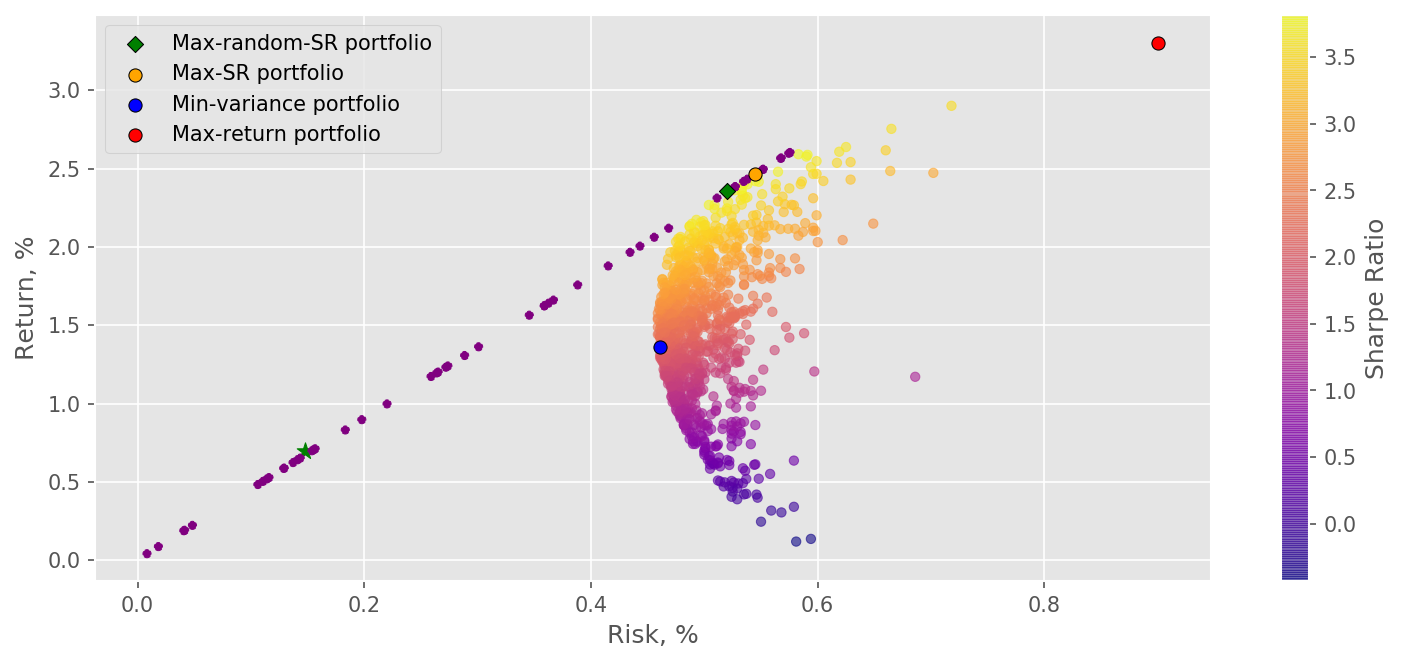

In [588]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
# plt.scatter(x, f(x), s=15, c='black')

plt.scatter(b0, a0, c='green', marker='*', s=70)
plt.scatter(portfolios['Risks'], portfolios['Returns'], s=20, alpha=0.6, c=sharpe_ratio, cmap='plasma')
plt.colorbar(label = 'Sharpe Ratio')

plt.scatter(x, f1(x, max_sharpe_ret, max_sharpe_risk), s=15, marker='o', linestyle='--', c='purple')
plt.scatter(sharpe['Risks'], sharpe['Returns'], s=30, c='g', marker='D', \
            edgecolor='black', label='Max-random-SR portfolio')#Random best sharpe ratio (0, 1)

plt.scatter(max_sharpe_risk, max_sharpe_ret, s=40, c='orange', edgecolor='black', \
           label='Max-SR portfolio') #sharpe ratio (0, 1)

plt.scatter(min_risk_risk, min_risk_ret, s=40, c='blue', edgecolor='black', \
           label='Min-variance portfolio') #min risk (0, 1)

plt.scatter(max_return_risk, max_return_ret, s=40, c='r', edgecolor='black', \
           label='Max-return portfolio') #max return (0, 1)

plt.xlabel('Risk, %')
plt.ylabel('Return, %')
plt.legend()
plt.show()

# Modeling

In [387]:
#download currency information
curr = yf.download('RUB=X', dates[1], datetime.date.today())['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [388]:
budget = 1000000
rf = 0.0037
names = ['SBER.ME','GAZP.ME', 'MTSS.ME', 'MGNT.ME', 'SNGS.ME', 'HYDR.ME', 'AFLT.ME', 'DSKY.ME', 'AAPL', 'IVV']
dates = ('2018-01-01', '2021-02-01')
m = 8 #stocks in currency 1
t = 0.5

In [403]:
class Model:
    def __init__(self, type_opt, names, dates, m, rf, t, curr, budget):
        self.type_opt = type_opt
        self.portfolio = OptimizationP(names, dates)
        self.rf = rf
        self.t = t
        self.costs = []
        self.res = []
        self.m = m
        self.curr = curr
        self.budget = budget
        self.forecast_data = []
        self.names = names
        self.portfolio.get_ts_csv()
        self.portfolio.resample_to_months()
        self.income = []
        
    def simulation(self):
        if self.type_opt == 'multi-criteria':
            self.portfolio.multi_criteria_opt((0, 1), 0.01, self.rf, self.t)
        else:
            self.portfolio.optimizeP(self.type_opt, (0, 1), 0.01, self.rf)
        self.costs = []
        self.res = []
        self.costs = np.array(self.portfolio.data.iloc[-1])

        q = np.dot(self.portfolio.w, self.budget)

        for i in range(self.m):
            self.res.append(q[i] / self.costs[i])

        for i in range(self.m, self.portfolio.n):
            self.res.append(q[i] / (self.curr[-1]*self.costs[i]))

        return self.res
    
    
    def quant(self):
        return f'Quantity {self.type_opt}: {[round(i) for i in self.simulation()]}'
    
    def forecast(self):
        self.forecast_data = []
        for name in self.names:
            model = ARIMA(self.portfolio.new_data[name], order=(1,2,1), freq='M')
            model_fit = model.fit()
            forecast = model_fit.forecast(5)
            self.forecast_data.append(np.array(forecast))

        self.forecast_data = np.array(self.forecast_data)[:,0]
        return self.forecast_data
    
    def portfolio_return(self):
        self.income = []
        s = self.simulation()
        self.forecast()
        
        for i in range(self.m):
            self.income.append(self.forecast_data[i]*s[i])

        for i in range(self.m, self.portfolio.n):
            self.income.append(self.forecast_data[i]*self.curr[-1]*s[i])
            
        return sum(self.income) - self.budget   

In [404]:
names_opt = ('maxReturn', 'minRisk', 'maxSharpe', 'maxSortino', 'minGenFun', 'minGenFunFree', 'multi-criteria')
total_return = []
quantities = []

for name in names_opt:
    model = Model(name, names, dates, m, rf, t, curr, budget)
    total_return.append(model.portfolio_return())
    quantities.append(model.quant())

In [405]:
total_return

[14337.772786180838,
 9649.131692842115,
 15295.133359552594,
 14337.772786212852,
 15610.996125913574,
 15610.995650366065,
 16804.282882737112]

In [406]:
for i, name in enumerate(names_opt):
    print(f'{name}: {round(total_return[i], 3)}')

maxReturn: 14337.773
minRisk: 9649.132
maxSharpe: 15295.133
maxSortino: 14337.773
minGenFun: 15610.996
minGenFunFree: 15610.996
multi-criteria: 16804.283


In [358]:
quantities

['Quantity maxReturn: [0.0, 743.0, 806.0, 0.0, 0.0, 0.0, 0.0, 2020.0, 29.0, 0.0]',
 'Quantity minRisk: [0.0, 827.0, 805.0, 0.0, 272.0, 131027.0, 0.0, 1712.0, 15.0, 2.0]',
 'Quantity maxSharpe: [0.0, 637.0, 1173.0, 0.0, 0.0, 0.0, 0.0, 1815.0, 22.0, 0.0]',
 'Quantity maxSortino: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0]',
 'Quantity minGenFun: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 505.0, 93.0, 0.0]',
 'Quantity minGenFunFree: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 505.0, 93.0, 0.0]',
 'Quantity multi-criteria: [0.0, 867.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2315.0, 48.0, 0.0]']